# Prediction of total COVID-19 infections in December 2023

In [45]:
# Prosze podac sciezke do folderu w ktorym bedzie notebook i zip z danymi
path = "C:/Users/dell/Downloads/DS1"

#### 1. Nazwa zespołu:
<br> The Overfitting Outliers
#### 2. Członkowie zespołu – imiona, nazwiska i numery indeksu:
<br> Jaźwiński Michał - 124246
<br> Kozłowska Emilia - 123036
<br> Warpas Martyna - 124290

### Packages

In [46]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from datetime import datetime
import lightgbm

from sklearn.metrics import mean_squared_error

### Functions used in further analysis

In [47]:
def features(df):
    
    df_with_feat = df.copy()
    df_with_feat['day_of_week'] = df_with_feat.index.dayofweek
    df_with_feat['quarter'] = df_with_feat.index.quarter
    df_with_feat['month'] = df_with_feat.index.month
    df_with_feat['year'] = df_with_feat.index.year
    df_with_feat['day_of_year'] = df_with_feat.index.dayofyear
    
    return df_with_feat

### Data preparation

In [48]:
# 1. Unzipping file

import zipfile
with zipfile.ZipFile('danehistorycznewojewodztwa.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [49]:
# 2. Scanning folder with data

import os

def scan_folder(parent):
    
    files_list = []
    # iterate over all the files in directory 'parent'
    for file_name in os.listdir(parent):
        if file_name.endswith(".csv"):
            # if it's a txt file, print its name (or do whatever you want)
            files_list.append(file_name)
        else:
            current_path = "".join((parent, "/", file_name))
            if os.path.isdir(current_path):
                # if we're checking a sub-directory, recursively call this method
                scan_folder(current_path)
                
    return files_list


files_list = scan_folder(path)  # Insert parent directory's path


# merging these files into one dataframe

merged_df = pd.DataFrame()

for f in files_list:
        
    day_df = pd.read_csv(f, sep=';', encoding='latin')
    day_df = pd.DataFrame(day_df.head(1))
    day_df['data'] = f[:8]
                
    merged_df = pd.concat([merged_df, day_df])

In [9]:
# 3. Preprocessing dataframe with basic data

merged_df = merged_df[['data'
                       , 'liczba_przypadkow'
                       , 'liczba_wszystkich_zakazen']]

merged_df = merged_df.fillna(value=0)
merged_df['liczba_zakazen_total'] = merged_df['liczba_przypadkow'] + merged_df['liczba_wszystkich_zakazen']
merged_df = merged_df[['data', 'liczba_zakazen_total']]

y = merged_df.set_index('data')
y.index = pd.to_datetime(y.index)

In [10]:
y

,liczba_zakazen_total
data,
2020-11-24,10141.0
2020-11-25,15360.0
2020-11-26,16846.0
2020-11-27,17059.0
2020-11-28,15183.0
...,...
2023-11-29,2505.0
2023-11-30,2381.0
2023-12-01,2412.0


### Data exploration

<AxesSubplot:xlabel='data'>

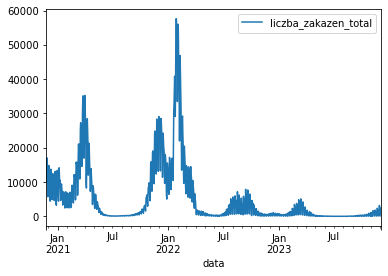

In [11]:
y.plot()

In [12]:
expl_df = features(y)

In [14]:
expl_df

,liczba_zakazen_total,day_of_week,quarter,month,year,day_of_year
data,,,,,,
2020-11-24,10141.0,1,4,11,2020,329
2020-11-25,15360.0,2,4,11,2020,330
2020-11-26,16846.0,3,4,11,2020,331
2020-11-27,17059.0,4,4,11,2020,332
2020-11-28,15183.0,5,4,11,2020,333
...,...,...,...,...,...,...
2023-11-29,2505.0,2,4,11,2023,333
2023-11-30,2381.0,3,4,11,2023,334
2023-12-01,2412.0,4,4,12,2023,335


In [15]:
expl_df.groupby(by=['year', 'month']).agg({'liczba_zakazen_total' : 'sum'})

liczba_zakazen_total
year month                      
2020 11                  91806.0
     12                 304432.0
2021 1                  218147.0
     2                  193609.0
     3                  613627.0
     4                  470300.0
     5                   80591.0
     6                    7542.0
     7                    3044.0
     8                    5787.0
     9                   18409.0
     10                 118133.0
     11                 514444.0
     12                 568168.0
2022 1                  777844.0
     2                  779389.0
     3                  295939.0
     4                   33666.0
     5                   11086.0
     6                    7418.0
     7                   54744.0
     8                  107319.0
     9                  116774.0
     10                  46938.0
     11                  12329.0
     12                  15741.0
2023 1                   10931.0
     2                   40145.0
     3                   76783.0
     4                   17705.0
     5                    3071.0
     6                     940.0
     7                     286.0
     8                     908.0
     9                    4235.0
     10                  10765.0
     11                  34633.0
     12                   4883.0

### Train/test split

In [16]:
# dataframes with one column - target
train = y.loc[y.index <= datetime(2023, 11, 15)]
test = y.loc[y.index > datetime(2023, 11, 15)]

In [17]:
train

,liczba_zakazen_total
data,
2020-11-24,10141.0
2020-11-25,15360.0
2020-11-26,16846.0
2020-11-27,17059.0
2020-11-28,15183.0
...,...
2023-11-11,1012.0
2023-11-12,113.0
2023-11-13,77.0


### Creating some features

In [18]:
# dataframes with target and features
train_df = features(train)
test_df = features(test)

In [19]:
train_df

,liczba_zakazen_total,day_of_week,quarter,month,year,day_of_year
data,,,,,,
2020-11-24,10141.0,1,4,11,2020,329
2020-11-25,15360.0,2,4,11,2020,330
2020-11-26,16846.0,3,4,11,2020,331
2020-11-27,17059.0,4,4,11,2020,332
2020-11-28,15183.0,5,4,11,2020,333
...,...,...,...,...,...,...
2023-11-11,1012.0,5,4,11,2023,315
2023-11-12,113.0,6,4,11,2023,316
2023-11-13,77.0,0,4,11,2023,317


### Building model

In [20]:
# Lists of variables names
X_names = ['day_of_week', 'quarter', 'month', 'year', 'day_of_year']
y_name = ['liczba_zakazen_total']

In [21]:
# Train and test sets - features and target column
X_train = train_df[X_names]
y_train = train_df[y_name]

X_test = test_df[X_names]
y_test = test_df[y_name]

In [23]:
# Looking for best parameters

import numpy as np
from tqdm import tqdm

# Objective function to minimalize mse
def objective(params):
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Parameters space
param_space = {
    'max_depth': range(1, 10),
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight' : range(5, 50, 5),
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'reg_alpha': range(1, 30, 1),
    'reg_lambda': range(1, 30, 1),
    'min_split_loss': range(1, 10)
}

# Number of iterations Random Search
num_iterations = 200

# Initialization of best parameters and best mse
best_params = None
best_mse = np.inf

# Random Search Loop
for iteration in tqdm(range(num_iterations)):
    params = {param: np.random.choice(values) for param, values in param_space.items()}
    mse = objective(params)

    if mse < best_mse:
        best_mse = mse
        best_params = params

# Best parameters for model:
print("Najlepsze parametry:", best_params)
print("Najlepszy logloss:", best_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.17it/s]

Najlepsze parametry: {'max_depth': 9, 'learning_rate': 1.0, 'gamma': 0.0, 'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 23, 'reg_lambda': 10, 'min_split_loss': 8}
Najlepszy logloss: 377934.20797879726


In [24]:
# v1: building model after parameteres optimization

reg_opt = xgb.XGBRegressor(max_depth=5
                           , learning_rate=0.5
                           , gamma=0.1
                           , min_child_weight=10
                           , subsample=0.7
                           , colsample_bytree=0.9
                           , reg_alpha=13
                           , reg_lambda=29
                           , min_split_loss=2)

reg_opt.fit(X_train
            , y_train
            , eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:7886.10568	validation_1-rmse:1631.43177
[1]	validation_0-rmse:6713.06543	validation_1-rmse:1551.65571
[2]	validation_0-rmse:6256.68091	validation_1-rmse:907.53195
[3]	validation_0-rmse:5162.97443	validation_1-rmse:844.38009
[4]	validation_0-rmse:4950.38120	validation_1-rmse:1644.59974
[5]	validation_0-rmse:4285.33851	validation_1-rmse:1462.66508
[6]	validation_0-rmse:3751.89282	validation_1-rmse:1410.93505
[7]	validation_0-rmse:3576.57612	validation_1-rmse:1194.04923
[8]	validation_0-rmse:3461.66660	validation_1-rmse:1169.54525
[9]	validation_0-rmse:3102.12317	validation_1-rmse:991.91266
[10]	validation_0-rmse:3068.87973	validation_1-rmse:1132.70991
[11]	validation_0-rmse:3020.65952	validation_1-rmse:1241.89137
[12]	validation_0-rmse:2961.22183	validation_1-rmse:1218.00609
[13]	validation_0-rmse:2877.74285	validation_1-rmse:1021.39991
[14]	validation_0-rmse:2762.91855	validation_1-rmse:989.30395
[15]	validation_0-rmse:2746.09749	validation_1-rmse:1102.62754
[16]	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=10, min_split_loss=2, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [25]:
# v2: building model with different parameters
reg = xgb.XGBRegressor(n_estimators=1000
                       , booster='gbtree'
                       , max_depth=15
                       , min_child_weight=0.5
                       , learning_rate=0.01
                       , early_stopping_rounds=50)

reg.fit(X_train
        , y_train
        , eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:10144.04068	validation_1-rmse:1779.24713
[1]	validation_0-rmse:10052.65024	validation_1-rmse:1775.13041
[2]	validation_0-rmse:9962.16195	validation_1-rmse:1771.05250
[3]	validation_0-rmse:9872.55034	validation_1-rmse:1767.01319
[4]	validation_0-rmse:9784.13950	validation_1-rmse:1763.01202
[5]	validation_0-rmse:9696.25970	validation_1-rmse:1759.04859
[6]	validation_0-rmse:9609.53949	validation_1-rmse:1755.12252
[7]	validation_0-rmse:9523.36344	validation_1-rmse:1751.23364
[8]	validation_0-rmse:9438.05116	validation_1-rmse:1747.38137
[9]	validation_0-rmse:9353.83633	validation_1-rmse:1743.56554
[10]	validation_0-rmse:9270.16599	validation_1-rmse:1739.78570
[11]	validation_0-rmse:9187.06048	validation_1-rmse:1736.04155
[12]	validation_0-rmse:9105.26128	validation_1-rmse:1732.33277
[13]	validation_0-rmse:9023.77085	validation_1-rmse:1728.65890
[14]	validation_0-rmse:8943.07458	validation_1-rmse:1725.01989
[15]	validation_0-rmse:8863.16912	validation_1-rmse:1721.41503


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=0.5, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Feature Importance

In [26]:
fi = pd.DataFrame(data=reg.feature_importances_
                 , index=reg.feature_names_in_
                 , columns=['fi'])

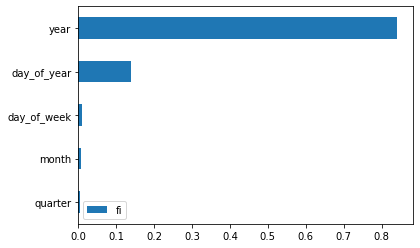

In [27]:
fi.sort_values(by='fi').plot(kind='barh')
plt.show()

### Prediction on train and test sets

In [28]:
# Prediction on train set
train_df['prediction'] = reg.predict(X_train)

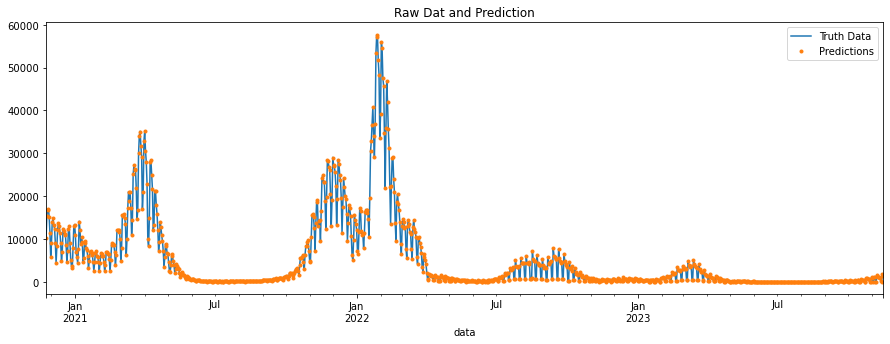

In [29]:
ax = train_df[['liczba_zakazen_total']].plot(figsize=(15, 5))
train_df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [30]:
# Prediction on test set
test_df['prediction'] = reg.predict(X_test)

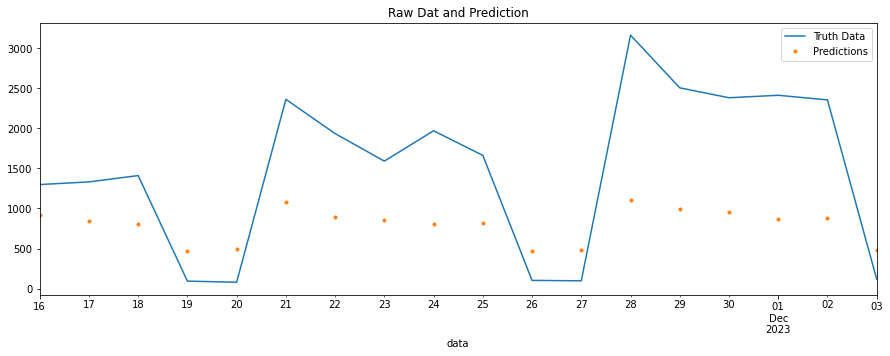

In [31]:
ax = test_df[['liczba_zakazen_total']].plot(figsize=(15, 5))
test_df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

### Prediction on December 2023

In [40]:
dec_date_df = pd.DataFrame({'data' : pd.date_range(start='20231201', end='20231231')})
dec_date_df = dec_date_df.set_index('data')
dec_feat_df = features(dec_date_df)

In [41]:
dec_feat_df['prediction'] = reg.predict(dec_feat_df)

In [42]:
dec_feat_df

,day_of_week,quarter,month,year,day_of_year,prediction
data,,,,,,
2023-12-01,4,4,12,2023,335,873.897705
2023-12-02,5,4,12,2023,336,875.026184
2023-12-03,6,4,12,2023,337,487.035248
2023-12-04,0,4,12,2023,338,489.177887
2023-12-05,1,4,12,2023,339,1173.839111
2023-12-06,2,4,12,2023,340,1027.129761
2023-12-07,3,4,12,2023,341,1007.836609
2023-12-08,4,4,12,2023,342,837.303406
2023-12-09,5,4,12,2023,343,796.483337


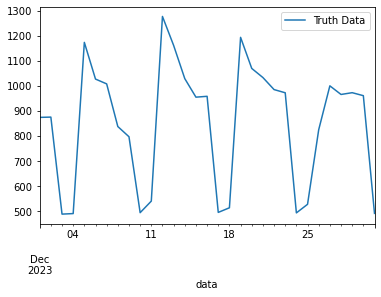

In [43]:
dec_feat_df['prediction'].plot(style='-')
plt.legend(['Truth Data', 'Predictions'])
plt.show()

### Sum of predictions in December 2023:

In [44]:
dec_feat_df['prediction'].sum().round()

26473.0